Traditionally, models used for object detection require labeled image datasets for training, and are limited to detecting the set of classes from the training data.

Zero-shot object detection, however, is supported by the OWL-ViT model which uses a different approach. OWL-ViT is an open-vocabulary object detector. It means that it can detect objects in images based on free-text queries without the need to fine-tune the model on labeled datasets.

OWL-ViT leverages multi-modal representations to perform open-vocabulary detection. It combines CLIP with lightweight object classification and localization heads. Open-vocabulary detection is achieved by embedding free-text queries with the text encoder of CLIP and using them as input to the object classification and localization heads. These heads associate images and their corresponding textual descriptions, and ViT processes image patches as inputs. The authors of OWL-ViT first trained CLIP from scratch and then fine-tuned OWL-ViT end to end on standard object detection datasets using a bipartite matching loss. With this approach, the model can detect objects based on textual descriptions without prior training on labeled datasets.

This guide shows how to use OWL-ViT:
1. to detect objects based on text prompts
2. for batch object detection
3. for image-guided object detection

# Libraries

In [1]:
pip install -q transformers

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import skimage
import requests
import numpy as np
from PIL import Image
from PIL import ImageDraw
import matplotlib.pyplot as plt
from transformers import pipeline, AutoProcessor, AutoModelForZeroShotObjectDetection

2024-09-10 21:02:32.971377: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Zero-shot object detection pipeline

In [3]:
# The simplest way to try out inference with OWL-ViT is to use it in a pipeline()
# Instantiate a pipeline for zero-shot object detection from a checkpoint on the Hugging Face Hub
checkpoint = "google/owlvit-base-patch32"
detector = pipeline(model=checkpoint, task="zero-shot-object-detection")

config.json:   0%|          | 0.00/4.42k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/613M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


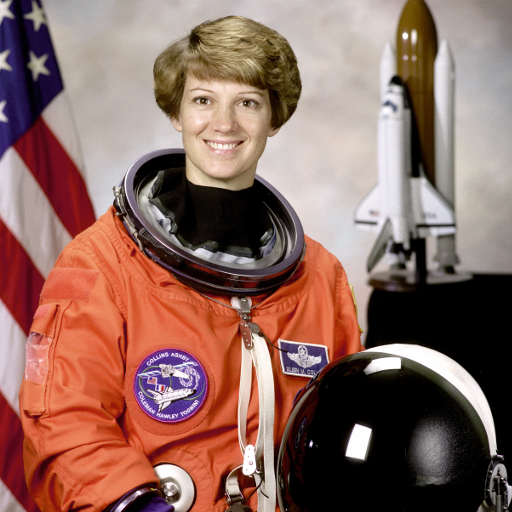

In [4]:
# Choose an image you’d like to detect objects in. 
# Here we’ll use the image of astronaut Eileen Collins...
# ...part of the NASA Great Images dataset
image = skimage.data.astronaut()
image = Image.fromarray(np.uint8(image)).convert("RGB")

image

In [5]:
# Pass the image into the pipeline
# Here we pass the image directly; other suitable options include a local path to an image or an image url
# NB: be sure to pass text descriptions for all items we want to query the image for (candidate labels)
text_descriptions = ["human face", "rocket", "nasa badge", "star-spangled banner"]
predictions = detector(
    image,
    candidate_labels=text_descriptions,
)

predictions

[{'score': 0.35713618993759155,
  'label': 'human face',
  'box': {'xmin': 180, 'ymin': 71, 'xmax': 271, 'ymax': 178}},
 {'score': 0.28099730610847473,
  'label': 'nasa badge',
  'box': {'xmin': 129, 'ymin': 348, 'xmax': 206, 'ymax': 427}},
 {'score': 0.21102406084537506,
  'label': 'rocket',
  'box': {'xmin': 350, 'ymin': -1, 'xmax': 468, 'ymax': 288}},
 {'score': 0.1379048079252243,
  'label': 'star-spangled banner',
  'box': {'xmin': 1, 'ymin': 1, 'xmax': 105, 'ymax': 509}},
 {'score': 0.11950060725212097,
  'label': 'nasa badge',
  'box': {'xmin': 277, 'ymin': 338, 'xmax': 327, 'ymax': 380}},
 {'score': 0.10649356245994568,
  'label': 'rocket',
  'box': {'xmin': 358, 'ymin': 64, 'xmax': 424, 'ymax': 280}}]

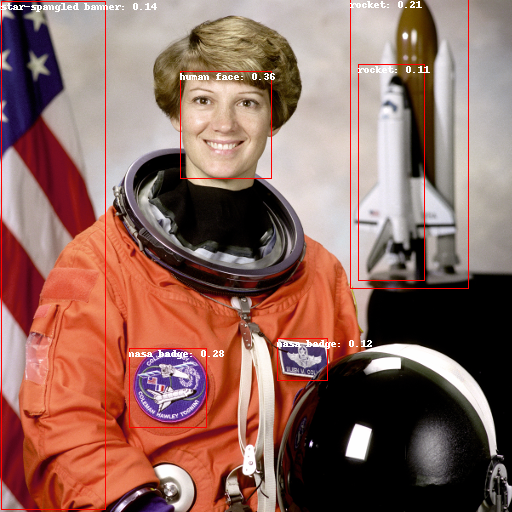

In [6]:
# Visualise the predictions by plotting the bounding box coordinates
draw = ImageDraw.Draw(image)
labels = []
scores = []

for prediction in predictions:
    box = prediction["box"]
    label = prediction["label"]
    score = prediction["score"]
    labels.append(label)
    scores.append(score)

    xmin, ymin, xmax, ymax = box.values()
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
    draw.text((xmin, ymin), f"{label}: {round(score,2)}", fill="white")

image

In [7]:
# Extract labels and scores to print them on screen (might add some clarity)
sorted(dict(zip(scores, labels)).items())

[(0.10649356245994568, 'rocket'),
 (0.11950060725212097, 'nasa badge'),
 (0.1379048079252243, 'star-spangled banner'),
 (0.21102406084537506, 'rocket'),
 (0.28099730610847473, 'nasa badge'),
 (0.35713618993759155, 'human face')]

# Zero-shot object detection manual workflow

In [8]:
# Load pre-trained model and associated preprocessor from a checkpoint
model = AutoModelForZeroShotObjectDetection.from_pretrained(checkpoint)
processor = AutoProcessor.from_pretrained(checkpoint)

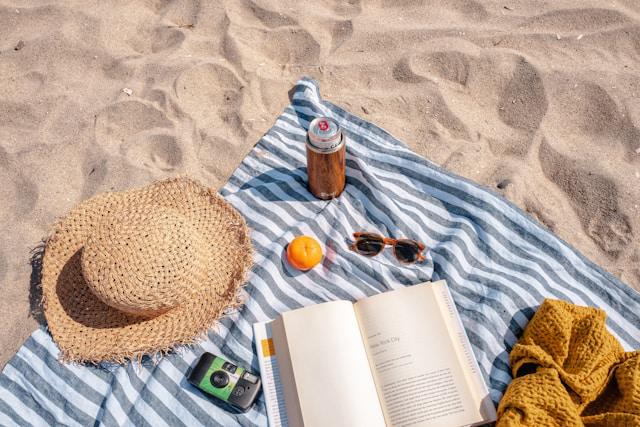

In [9]:
# Load a different image using a different approach to switch things up
url = "https://unsplash.com/photos/oj0zeY2Ltk4/download?ixid=MnwxMjA3fDB8MXxzZWFyY2h8MTR8fHBpY25pY3xlbnwwfHx8fDE2Nzc0OTE1NDk&force=true&w=640"
im = Image.open(requests.get(url, stream=True).raw)
im

In [10]:
# Preprocess the inputs ready for the model
# The (pre)processor combines the image input and the text query/description
text_queries = ["hat", "book", "sunglasses", "camera"]
inputs = processor(text=text_queries, images=im, return_tensors="pt")

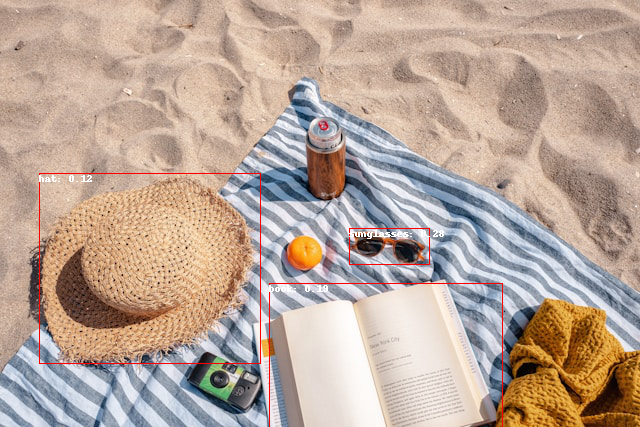

In [11]:
# Pass the input from the processor into the model, post-process, and visualise results
with torch.no_grad():
    outputs = model(**inputs)
    target_sizes = torch.tensor([im.size[::-1]])
    
    # NB: the image processor resized images before feeding them to the model...
    # ...you need to use the post_process_object_detection() method to reconcile predicted bounding boxes...
    # ...between the processed and the original image
    results = processor.post_process_object_detection(outputs, threshold=0.1, target_sizes=target_sizes)[0]

draw = ImageDraw.Draw(im)

scores = results["scores"].tolist()
labels = results["labels"].tolist()
boxes = results["boxes"].tolist()

for box, score, label in zip(boxes, scores, labels):
    xmin, ymin, xmax, ymax = box
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
    draw.text((xmin, ymin), f"{text_queries[label]}: {round(score,2)}", fill="white")

im

In [12]:
# Extract labels and scores to print them on screen (might add some clarity)
label_assigned = [text_queries[i] for i in labels]
sorted(dict(zip(scores, label_assigned)).items())

[(0.11562091112136841, 'hat'),
 (0.1864943653345108, 'book'),
 (0.27863067388534546, 'sunglasses')]

In [13]:
# TO DO: bounding boxes not aligned in above image. Needs alignment.

# Batch Processing

In [14]:
# Batch process multiple images for object detection
# Below we use both the astronaut and the beach image together

# Pass images as lists of PIL images, PyTorch tensors, or NumPy arrays
images = [image, im]

# Pass text queries as a nested list to the processor
text_queries = [
    ["human face", "rocket", "nasa badge", "star-spangled banner"],
    ["hat", "book", "sunglasses", "camera"],
]

inputs = processor(text=text_queries, images=images, return_tensors="pt")

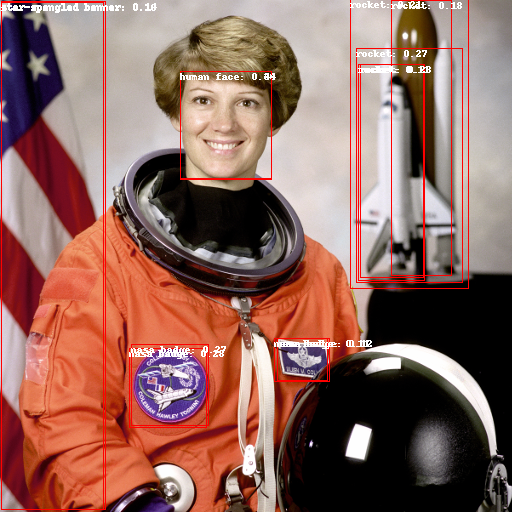

In [15]:
# Previously we passed the single image’s size as a tensor, but we could have also passed in a tuple
# Here, where we have several images, pass in a list of tuples for post-processing
with torch.no_grad():
    outputs = model(**inputs)
    target_sizes = [x.size[::-1] for x in images]
    results = processor.post_process_object_detection(outputs, threshold=0.1, target_sizes=target_sizes)

# We'll visualise the predictions for the first image (index 0)
image_idx = 0
draw = ImageDraw.Draw(images[image_idx])

scores = results[image_idx]["scores"].tolist()
labels = results[image_idx]["labels"].tolist()
boxes = results[image_idx]["boxes"].tolist()

for box, score, label in zip(boxes, scores, labels):
    xmin, ymin, xmax, ymax = box
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
    draw.text((xmin, ymin), f"{text_queries[image_idx][label]}: {round(score,2)}", fill="white")

# NB: Reload images if you want fresh bounding boxes instead of overlaid ones
images[image_idx]

# Image-guided object detection

In addition to zero-shot object detection with text queries, OWL-ViT offers image-guided object detection. This means you can use an image query to find similar objects in the target image. Unlike text queries, only a single query image is allowed.

Let’s take an image with two cats on a couch as a target image, and an image of a single cat as a query

In [16]:
# Load image on which to perform object detection
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image_target = Image.open(requests.get(url, stream=True).raw)

In [17]:
# Load image to use as query
query_url = "http://images.cocodataset.org/val2017/000000524280.jpg"
query_image = Image.open(requests.get(query_url, stream=True).raw)

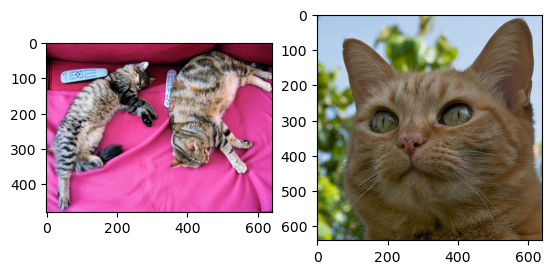

In [18]:
# Plot the images
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image_target)
ax[1].imshow(query_image)

In [19]:
# Be sure to use the query image for preprocessing step
inputs = processor(images=image_target, query_images=query_image, return_tensors="pt")

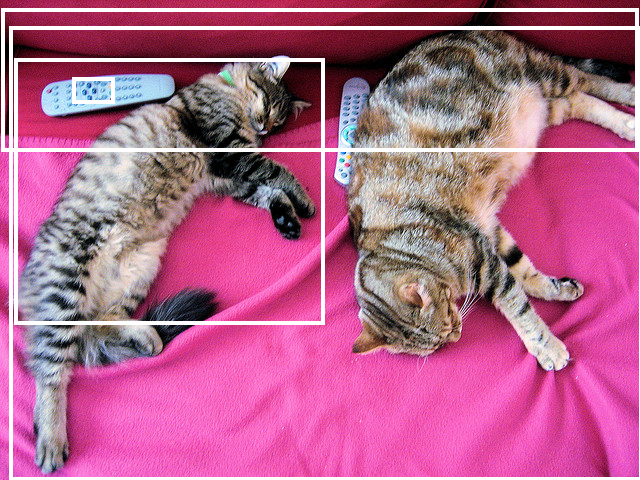

In [20]:
# Be sure to pass inputs to model.image_guided_detection() instead of model()
with torch.no_grad():
    outputs = model.image_guided_detection(**inputs)
    target_sizes = torch.tensor([image_target.size[::-1]])
    results = processor.post_process_image_guided_detection(outputs=outputs, target_sizes=target_sizes)[0]

draw = ImageDraw.Draw(image_target)

scores = results["scores"].tolist()
boxes = results["boxes"].tolist()

# Draw bounding boxes without text labels this time
for box, score, label in zip(boxes, scores, labels):
    xmin, ymin, xmax, ymax = box
    draw.rectangle((xmin, ymin, xmax, ymax), outline="white", width=4)

# Plot target image with predictions
# Note there's 4 predictions here - 1 correct, 1 debatable, 2 incorrect... model might require more fine-tuning
image_target